# Painting by prime number
Two weeks ago I stumbled upon the concept of [prime portraits](http://archive.bridgesmathart.org/2016/bridges2016-359.pdf). Unfortunatly I could not find the code, and I loved to see the same portraits in color. I decided that I could create this in Python and set off to work! Below is the Jupyter Notebook with the code I used to generate the following results:

![starry night](http://www.pinchofintelligence.com/wp-content/uploads/2018/06/starrynight-prime-386kb.png)
![mona lisa](http://www.pinchofintelligence.com/wp-content/uploads/2018/05/monalisa-prime.png)
![My face](http://www.pinchofintelligence.com/wp-content/uploads/2018/06/rolandface-prime.png)

## The concept
The idea of a prime portrait is that if you take a prime number, format it like a normal number with X digits per line, and give each digit a color you get something that resembles an image: 

You create them by taking an image, and converting it to an image with only 10 colors. You select a digit for each color, and generating many similar images with a little bit of noise added. If the digits in this image with only 10 colors are put after one another, and this forms a prime number, you found your prime portrait!


In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import skimage.transform
import skimage.io
from sklearn.cluster import KMeans
import scipy.misc
from PIL import Image, ImageFont, ImageDraw

import numpy as np

from multiprocessing import Pool
import time
import random

## Testing for primality
When working with extremely long primes the naive method of testing each divisor will take way too much time. Instead we take a probabilistic approach to the prime numbers. I downloaded the following code for the Miller-Rabin primality test from Rosetta code to check for primality:

In [2]:
def try_composite(a, d, n, s):
    # test the base a to see whether it is a witness for the compositeness of n
    if pow(a, d, n) == 1:
        return False
    for i in range(s):
        if pow(a, 2**i * d, n) == n-1:
            return False
    return True # n is definitely composite

    
def is_probable_prime(n, mrpt_num_trials = 5):
    """
    Miller-Rabin primality test.
 
    A return value of False means n is certainly not prime. A return value of
    True means n is very likely a prime.

    """
    assert n >= 2
    # special case 2
    if n == 2:
        return True
    # ensure n is odd
    if n % 2 == 0:
        return False
    # write n-1 as 2**s * d
    # repeatedly try to divide n-1 by 2
    s = 0
    d = n-1
    while True:
        quotient, remainder = divmod(d, 2)
        if remainder == 1:
            break
        s += 1
        d = quotient
    assert(2**s * d == n-1)
                                     
    for i in range(mrpt_num_trials):
        a = random.randrange(2, n)
        if try_composite(a, d, n, s):
            return False
        
    return True # no base tested showed n as composite

assert is_probable_prime(2)
assert is_probable_prime(3)
assert not is_probable_prime(4)
assert  is_probable_prime(5)
assert not is_probable_prime(123456789)
primes_under_1000 = [i for i in range(2, 1000) if is_probable_prime(i)]
assert len(primes_under_1000) == 168
assert primes_under_1000[-10:] == [937, 941, 947, 953, 967, 971, 977, 983, 991, 997]
assert is_probable_prime(6438080068035544392301298549614926991513861075340134\
3291807343952413826484237063006136971539473913409092293733259038472039\
7133335969549256322620979036686633213903952966175107096769180017646161\
851573147596390153)
assert not is_probable_prime(7438080068035544392301298549614926991513861075340134\
3291807343952413826484237063006136971539473913409092293733259038472039\
7133335969549256322620979036686633213903952966175107096769180017646161\
851573147596390153)


## Generating the images
The basis of the algorithm is generating images with only 10 possible color values. Although I did not know what a common approach to this is I opted for applying a k-means algorithm on a reshaped image (so each pixel is a point in 3D speace) and using the 10 created clusters as color values. 

Important for the prime generation is that you ad a little bit of noise to the original image to create images that look the same, but actually are a different number (a new chance for a prime number!). 

In [3]:
def get_k_means(image):
    pointcloud = np.reshape(image, (-1, 3))
    kmeans = KMeans(n_clusters=10).fit(pointcloud)
    return kmeans

def create_numbered_image(image, kmeans):
    """
    Turns an RGB image into an image with the labels of clusters of the supplied kmeans classifier. 
    """
    # apply noise
    stdev = np.std(image)
    random_noise = np.random.random_sample(size=image.shape)*(stdev/3)
    image = image + random_noise
    
    orig_shape = image.shape
    image = np.reshape(image, (-1, 3))

    numbered_image = kmeans.predict(image)
    numbered_image = np.reshape(numbered_image, orig_shape[:2])
    
    # make sure the end is uneven
    if numbered_image[-1,-1]%2==0:
        numbered_image[-1,-1] += 1

    return numbered_image

def numbered_image_to_normal_image(numbered_image, kmeans):
    """
    Turns an image with only values between 0 and 9 into a colored image by using the cluster centers 
    of the supplied kmeans classifier. 
    """
    shape = (numbered_image.shape[0], numbered_image.shape[1], 3)
    image = np.zeros(shape)
    for label, color in zip(range(10), kmeans.cluster_centers_):
        image[numbered_image==label] = color
    return image


### Numerised image examples
Here I create a few examples of numerised images. As you can see each image is slightly different, but you can still recognise the original picture. This is crucial for us, as this allows us to generate multiple numerised images that we can test for primality.

/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


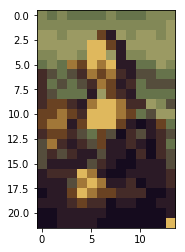

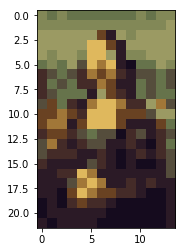

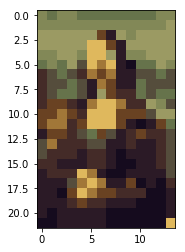

In [4]:

def load_and_resize_image(filename, resize_factor=18):
    image = skimage.io.imread(filename)
    image = image.astype(np.float64)
    image = image / 255.
    
    oldshape = image.shape
    resized_image = skimage.transform.resize(image, (oldshape[0]//resize_factor, oldshape[1]//resize_factor))

    return resized_image

resized_image = load_and_resize_image('input_pictures/monalisa.jpg')
kmeans = get_k_means(resized_image)
for _ in range(3):
    n_image = create_numbered_image(resized_image, kmeans)
    normal_image = numbered_image_to_normal_image(n_image, kmeans)
    
    plt.imshow(normal_image)
    plt.show()

## Helper functions
I had to create some helper functions to return strings, integers, and load and show images: 

In [5]:
def image_to_number(numbered_image):
    to_be_number = numbered_image.reshape(-1)
    as_string = ''.join([str(int(x)) for x in to_be_number])
    as_int = int(as_string)
    return as_int, as_string


def show_and_save_image(image, n_image, filename, fontsize=16):
    oldshape = image.shape
    resized_image= scipy.misc.imresize(image,(oldshape[0]*fontsize, oldshape[1]*fontsize), interp='nearest')
    img = Image.fromarray(resized_image).convert("RGBA")
    txt = Image.new('RGBA', img.size, (255,255,255,0))

    draw = ImageDraw.Draw(txt)
    font = ImageFont.truetype("pirulen rg.ttf", fontsize)
    for y_i, totype in enumerate(n_image):
        for x_i, letter in enumerate(totype):
            xpos = x_i * fontsize + 1
            ypos = y_i * fontsize
            if letter == 1:
                xpos += 4
            draw.text((xpos, ypos),str(letter),(255,255,255, 128),font=font)
    img = Image.alpha_composite(img, txt)    

    img.save(filename)
    plt.figure(figsize=(20,20))
    plt.imshow(img)
    plt.show()

def result_filename(filename):
    return filename.split('.')[0] + "-prime.png"

To verify if something is a good prime portrait I made the following helper functions: 

In [6]:
def is_good_prime_portrait(n_image):
    integer, string = image_to_number(n_image)
    if is_probable_prime(integer): 
        return integer, string, n_image
    else:
        return None
    
    
def print_result(string, n_image):
    print(string)
    print("-"*100)
    for line in n_image:
        print(''.join([str(x) for x in line]))


## Multi threaded searching
At first I created a single-threaded solution that worked. However: I became annoyed that my laptop with multiple cores could work harder on multiple numbers at the same time so I rewrote it as multi-threaded functions: 


In [7]:
def print_result(string, n_image):
    print("Found a result: " + "-"*100)
    print(string)
    print("Represented as portrait:" + "-"*100)
    for line in n_image:
        print(''.join([str(x) for x in line]))

def multi_threaded_prime_generator(resized_image, kmeans, filename, threads=4, log_process=True):
    image_generator = (create_numbered_image(resized_image, kmeans) for _ in range(1000000))
    start = time.time() 
    with Pool(threads) as pool:
        results = pool.imap_unordered(is_good_prime_portrait, image_generator)
        total_results = 0
        
        for result in results:
            total_results += 1
            
            # Possibly log time spend searching this prime number
            if log_process and total_results%30==0:
                elapsed = time.time()
                elapsed = elapsed - start
                print("Seconds spent in (function name) is {} time per result: {}".format(str(elapsed), str(elapsed/total_results)))

                
            if result != None: 
                # Found a prime number, print it and save it!
                integer, string, n_image = result
                print_result(string, n_image)
                normal_image = numbered_image_to_normal_image(n_image, kmeans)
                plt.imshow(normal_image)
                plt.show()
                show_and_save_image(normal_image, n_image, result_filename(filename))
                break
                
                
def search_prime_portrait(filename, resize_factor=16, log_process=True, threads=4):
    resized_image = load_and_resize_image(filename, resize_factor=resize_factor)
    print("Working with size " + str(resized_image.shape))
    kmeans = get_k_means(resized_image)
    multi_threaded_prime_generator(resized_image, kmeans, filename, log_process=log_process, threads=threads)



## Generating prime portraits
Now that we defined all functionality it's finally time to generate the prime portraits! Try to play around with it, and try to feed your own images. Note the resize_factor variable you can pass to the function: the bigger this is the fast you generate a prime portrait, and the smaller it is the longer it takes to generate a prime portrait. See below for more information on the exponential time it takes to generate larger prime portraits. 

Working with size (19, 13, 3)


/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Found a result: ----------------------------------------------------------------------------------------------------
4440444444442444444244242222222331222222222869174222044419531002280001368780008000893170000000488551802033318669384533331966958182851813501178385111881737880888181781118883118777171811899917711117711555318711711333881171177711817777717717777777717
Represented as portrait:----------------------------------------------------------------------------------------------------
4440444444442
4444442442422
2222233122222
2222869174222
0444195310022
8000136878000
8000893170000
0004885518020
3331866938453
3331966958182
8518135011783
8511188173788
0888181781118
8831187771718
1189991771111
7711555318711
7113338811711
7771181777771
7717777777717


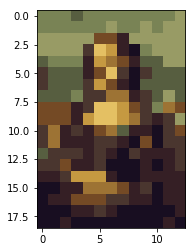

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  # Remove the CWD from sys.path while we load stuff.


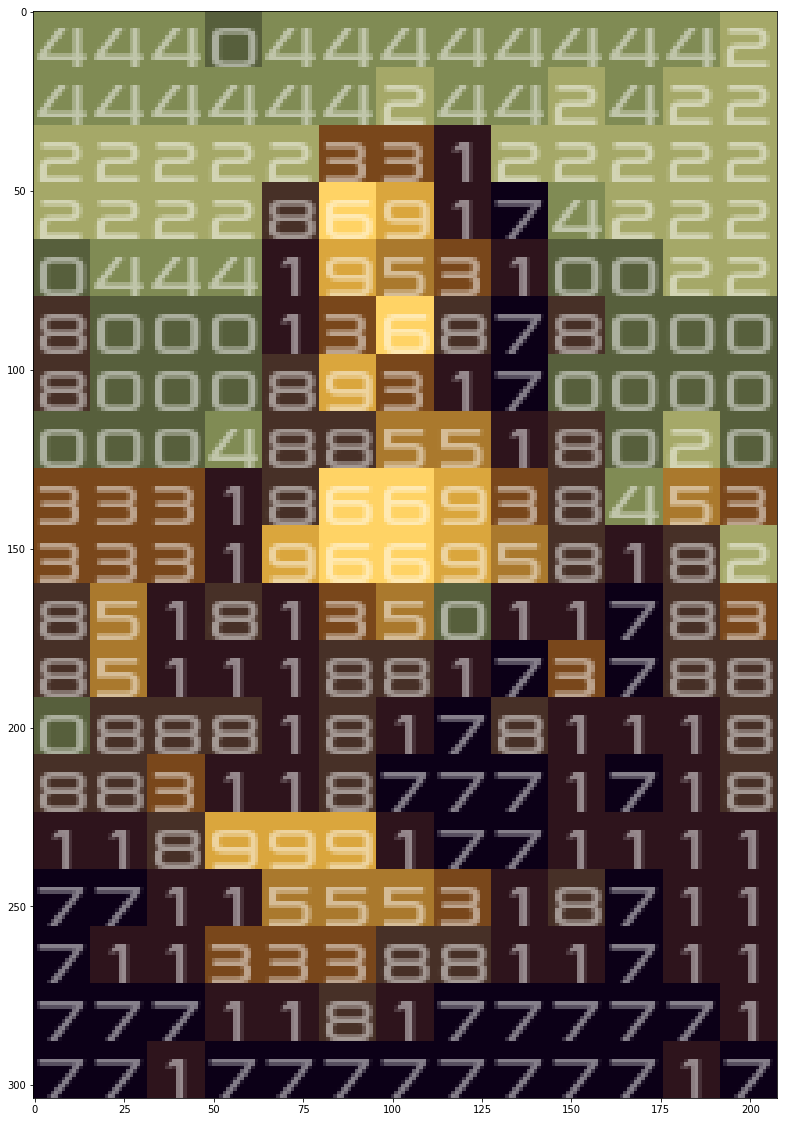

Working with size (18, 15, 3)


In [ ]:
folder = 'input_pictures/'

filenames = [
    folder + 'monalisa.jpg',
    #folder + 'sunflowers.jpg',
    #folder + 'starrynight.jpg'
]
filename = filenames[0]

for filename in filenames:
    search_prime_portrait(filename, resize_factor=20, log_process=False, threads=4)


## How does this scale?
Appartenlty the largest known prime number is 22338618 long (http://primes.utm.edu/largest.html). This would allow us to create a 4726 * 4726 prime portrait, which would be a prime portrait in 4K...

However: I noticed that finding prime numbers does not really scale. The length of the prime number grows quadratically with the resolution of your images, which causes big problems. Although the probability that you find a prime number only decreases linearly with the length of the prime number, it decreases quadratically when you get larger image resolutions. I plotted it in this image to show the effect up to 300x300:



In [ ]:
def trials_expected_img(w,h):
    return 2.3*w*h

needed = [trials_expected_img(x,x) for x in range(1,300)]
plt.plot(needed)

But what's even worse is that the time to compute if a number is a prime number in the Python implementation I use grows quadratically with the length of the prime number. I also decided to plot this for my laptop up to an image resolution of 30x30:

In [ ]:
def time_expected_img(w,h):
    order = w*h
    start = time.time() 
    for _ in range(100):
        posprim = random.randrange(10**(order-1), 10**order)    
        a = is_probable_prime(posprim)
    end = time.time()
    return end - start

    
test_range = range(2,30,4)
time_needed = [time_expected_img(x,x) for x in test_range]
plt.plot(test_range, time_needed)
plt.title("Seconds expected to calculate if an XxY image is a prime portrait ")
plt.xlabel("Width image")
plt.ylabel("Expected seconds")

Combining both linear curves you can easily estimate the expected time you need to find a portrait of a certain size:

In [ ]:
total_needed = [trials_expected_img(x,x)*time_expected_img(x,x) for x in test_range]
plt.plot(test_range, total_needed)
plt.title("Seconds expected to find an XxY prime portrait ")
plt.xlabel("Width image")
plt.ylabel("Expected seconds")

If you can find a more efficient Python implementation of a probabilistic prime checker, or implement it in a language more suitable to high demand computation you can get this time down. Each additional computer core also reduces this time a bit, but for now we can not expect 4K prime portraits anytime toon. 

## Conclusion and artworks
The last couple of weeks I really enjoyed letting my computer find prime portraits. Here are some of the "artworks" my computer found I particulary liked: 
![Sunflowers](http://www.pinchofintelligence.com/wp-content/uploads/2018/05/sunflowers-prime.png)
![Great wave](http://www.pinchofintelligence.com/wp-content/uploads/2018/06/greatwave-prime-big.png)
![Pearl](http://www.pinchofintelligence.com/wp-content/uploads/2018/06/1200px-Girl_with_a_Pearl_Earring-prime.png)

## Celebrity artworks
Although pictures of existing art often turn our pretty well it turns out that it's difficult to create good looking prime portraits for people. I decided to try some portraits for people I like to follow online. It turns out that finding good prime portraits is difficult, as the result image still has to look good with only ten colors. Images that turned our well are: 

#### Ionica Smeets
Writes interesting articles in a Dutch newspaper every Saturday, and got featured a while ago in the Dutch comic called "Donald Duck": 
![Ionica Smeets](http://www.pinchofintelligence.com/wp-content/uploads/2018/06/ionica_duck-prime.png)
#### Brady Haran
Makes interesting videos about mathematical concepts on the Numberphile Youtube channel. Also: has a cute dog ;)
![Brady Haran](http://www.pinchofintelligence.com/wp-content/uploads/2018/06/brady-prime.png)

## Requests
As I put the code online you can try to generate some prime portraits for yourself! If you really think I should try a certain artwork, feel free to reach out to me. Also: if you have a good idea what to do with these results, feel free to reach out. I know that I personally am going to hang the prime version of Starry Night on my wall!
